In [12]:
import numpy as np # linear algebra
from sklearn.model_selection import train_test_split #train_test_split
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt #plot graphs
import os #os working
import cv2 #openCV for image processing
from sklearn.model_selection import GridSearchCV #for hyper parameter optimization
from sklearn.metrics import classification_report, f1_score, make_scorer #metrics
from sklearn.svm import SVC #SVM Class
from sklearn.preprocessing import Normalizer, LabelEncoder #normalizing data
from tensorflow.keras.layers import * #import all layers
from tensorflow.keras import Model #import model
from tensorflow.keras import models
from tensorflow.keras import Sequential #for developing s sequential model

In [13]:
y=[] #empty lists to store images and labels
X=[]
for dirname, _, filenames in os.walk('./data'): #read data from the dir
    for filename in filenames: #loop through files
        if filename!="Readme.txt":
            b=plt.imread(os.path.join(dirname, filename)) #if filename is not readme then read the images
       
            try:
                b= cv2.cvtColor(b,cv2.COLOR_GRAY2RGB) #convert the images to RGB channel
            except:
                pass
            b=cv2.resize(b, (160,160),interpolation = cv2.INTER_AREA) #reize to 160by160

            if b.shape==(160,160,3) : #If shape is correct

                y.append(int(filename[7:9])) #append label to Y list
                X.append(b) #append image to X list
            else:
                print(face.shape) #shape of the input image

In [14]:
#sort according to the person and add all images to separte subject
data=[]
for i in range(1,16):
    person=[]
    for u in range(len(y)):
        if y[u]==i:
            
            person.append(X[u])
    data.append([person, i*len(person)])
    print(str(len(person))+" images  for class "+ str(i))

11 images  for class 1
11 images  for class 2
11 images  for class 3
11 images  for class 4
11 images  for class 5
11 images  for class 6
11 images  for class 7
11 images  for class 8
11 images  for class 9
11 images  for class 10
11 images  for class 11
11 images  for class 12
11 images  for class 13
11 images  for class 14
11 images  for class 15


In [15]:
import random #random number generation
random.seed(42)
newX1=[] #new empty list
newX2=[] #new empty list
newY=[]
for i in range(len(data)):
    parts= int(len(data[i][0])/2)
    #positive data sampling 
    for u in range(parts):
        newX1.append(data[i][0][u])
        newX2.append(data[i][0][u+parts])
        newY.append(0)
    #negative data sampling
    for uu in range(parts):
        
        numbers = list(range(0,i)) + list(range(i+1,11))
        r = random.choice(numbers) #get a random number
        g = random.randint(0,len(data[r][0])-1)
        newX1.append(data[i][0][uu])
        newX2.append(data[r][0][g])
        newY.append(1)

print("Target values count: "+ str(np.unique(newY, return_counts=True)))

Target values count: (array([0, 1]), array([75, 75], dtype=int64))


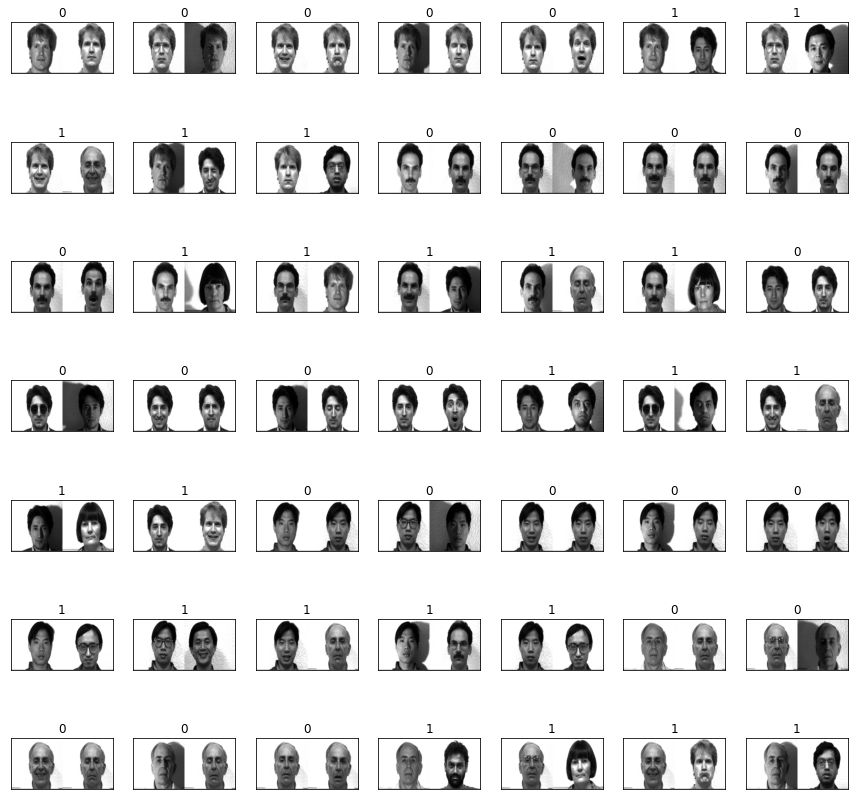

In [16]:
fig=plt.figure(figsize=(15, 15)) #create plot and plot the subject images
columns = 7
rows = 7
for i in range(1, columns*rows +1):
    ax=fig.add_subplot(rows, columns, i)
    plt.imshow(np.concatenate([newX1[i-1],newX2[i-1]], axis=1))
    ax.title.set_text(newY[i-1])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [17]:
c = list(zip(newX1, newX2, newY)) #create a list from the zipped files
random.shuffle(c) #shuffle the data
a, b, y = zip(*c) #unpacking

In [19]:
# Xpca.shape[0],Xpca.shape[1]

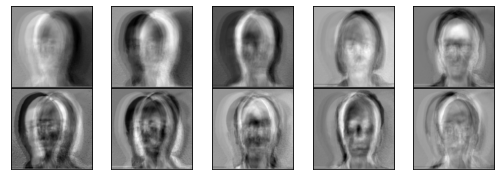

In [20]:
Xpca=np.array(a) #convert to a np.array
Xpca=Xpca.reshape(Xpca.shape[0],Xpca.shape[1]*Xpca.shape[2]*Xpca.shape[3]) #reshape the existing shapes
from sklearn.decomposition import PCA #for using principal component analysis

faces_pca = PCA(n_components=0.9)
faces_pca.fit(Xpca) #fit the pca on reshaped images
fig, axes = plt.subplots(2,5,figsize=(9,3),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.interp(faces_pca.components_[i], (min(faces_pca.components_[i]),max(faces_pca.components_[i])), (0, 255)).reshape(160,160,3).astype("int"))

In [21]:
base_model = models.load_model('./files/model/facenet_keras.h5') #laod FaceNet for feature extraction

base_model.load_weights("./files/weights/facenet_keras_weights.h5") #load pretrained weights
base_model.trainable=False #set the top layers to non-trainable

In [22]:
output1=base_model.predict(np.array(a)/255) #predict on an image
output2=base_model.predict(np.array(b)/255) #predict on another image

In [23]:
indexes1=[i for i,x in enumerate(y) if x == 1] #set lables
indexes0=[i for i,x in enumerate(y) if x == 0]

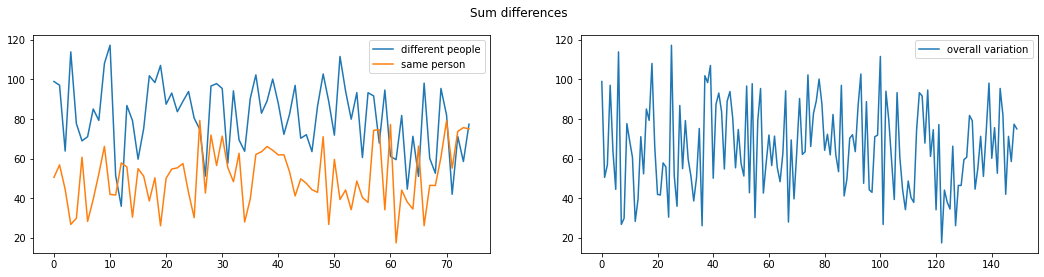

In [24]:
#find the variation in the data by plotting values and absolute differences
arr=[]
su=[]
for s in range(len(output1)):
    oo = np.abs(np.subtract(np.array(output1[s]),np.array(output2[s])))
    arr.append(oo)
    su.append(oo.sum())
    
a = np.array(su)
su1=list(a[indexes1])
su0=list(a[indexes0])

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(18, 4)
fig.suptitle("Sum differences")
axs[0].plot(list(range(75)),su1, list(range(75)),su0)
axs[0].legend(["different people", "same person"])
#axs[0].title("Euclidean distance")
axs[1].plot(list(range(150)),su)
axs[1].legend(["overall variation"])

In [25]:
#Descriibe the data
from scipy import stats
import statistics
print(stats.describe(su))
print("median "+str(statistics.median(su)))

DescribeResult(nobs=150, minmax=(17.442598, 117.149734), mean=65.75116, variance=500.5909, skewness=0.12109102308750153, kurtosis=-0.8037645744099433)
median 63.57733154296875


In [26]:
scorer = make_scorer(f1_score, average='macro') #metric evaluation
X_train, X_test,y_train,y_test= train_test_split(arr,y,test_size=0.2, random_state=42) #spliting the dataset

#selection of hyperparameter for optimization
tuned_parameters = [{'kernel': ['rbf','poly','linear'], 'gamma': [1e-3, 1e-4, 1e-5],
                     'C': [1, 10, 100, 1000]}]
scores = ['precision', 'recall']
#for score in scores:

#use GridSearchCV for finding the optimal hyperparameters
clf = GridSearchCV(SVC(), tuned_parameters, scoring=scorer)
clf.fit(Normalizer().fit(X_train).transform(X_train), y_train) #fir the model to find hyperparameter
params=clf.best_params_
print(clf.best_params_)
cv= SVC(C=params["C"], gamma= params["gamma"], kernel=params["kernel"]) #using SVM for the classification with best parameters
cv.fit(Normalizer().fit(X_train).transform(X_train), y_train) #fit model on normalized dataset

y_pred = cv.predict(Normalizer().fit(X_test).transform(X_test)) #predict on normalized test dataset
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


,precision,recall,f1-score,support
0,0.833333,0.588235,0.689655,17.0
1,0.611111,0.846154,0.709677,13.0
accuracy,0.700000,0.700000,0.700000,0.7
macro avg,0.722222,0.717195,0.699666,30.0
weighted avg,0.737037,0.700000,0.698331,30.0


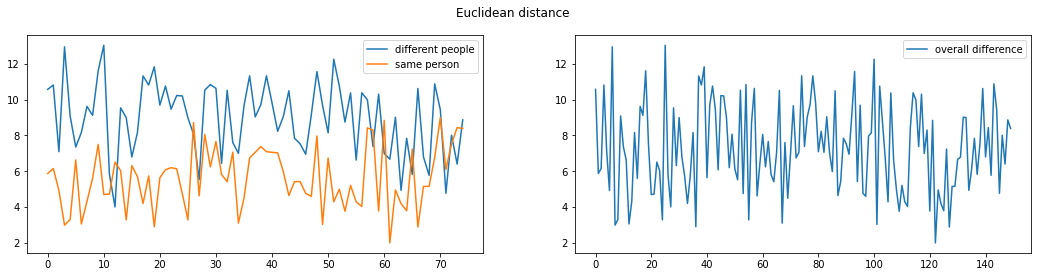

In [49]:
#for finding euclidean distance between the images and target labels
import scipy
euc=[]
for s in range(len(output1)):
    oo = scipy.spatial.distance.euclidean(np.array(output1[s]),np.array(output2[s]))
    euc.append(oo)
a = np.array(euc)
euc1=list(a[indexes1])
euc0=list(a[indexes0])

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(18, 4)
fig.suptitle("Euclidean distance")
axs[0].plot(list(range(75)),euc1, list(range(75)),euc0)
axs[0].legend(["different people", "same person"])
#axs[0].title("Euclidean distance")
axs[1].plot(list(range(150)),euc)
axs[1].legend(["overall difference"])

In [50]:
#describing the statistics of the model
print(stats.describe(euc))
print("median "+str(statistics.median(euc)))

DescribeResult(nobs=150, minmax=(1.9798132181167603, 13.037545204162598), mean=7.288673446178437, variance=6.229111607973249, skewness=0.11613394717725595, kurtosis=-0.805919209425205)
median 7.052937746047974


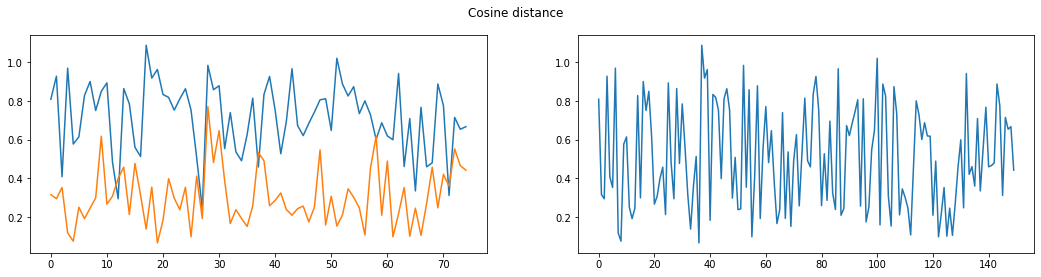

In [51]:
#for finding the cosine difference
cos=[]
for s in range(len(output1)):
    oo = scipy.spatial.distance.cosine(np.array(output1[s]),np.array(output2[s]))
    cos.append(oo)
a = np.array(cos)
cos1=list(a[indexes1])
cos0=list(a[indexes0])
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(18, 4)
fig.suptitle("Cosine distance")
axs[0].plot(list(range(75)), cos1, list(range(75)),cos0)
#axs[0].title("Euclidean distance")
axs[1].plot(list(range(150)),cos)

In [52]:
print(stats.describe(cos))
print("median "+str(statistics.median(cos)))

DescribeResult(nobs=150, minmax=(0.06744158267974854, 1.087137296795845), mean=0.5118078757822514, variance=0.07001131977171271, skewness=0.1779168464500461, kurtosis=-1.1853864605258442)
median 0.4825907349586487


# Siamese Network

In [53]:
c = list(zip(newX1, newX2, newY)) #create datapoints lists
random.shuffle(c) # shuffle data
a, b, y = zip(*c) #unpacking

In [60]:
features=Model(base_model.input, base_model.output) #get features from the pretrained model
import tensorflow.keras.backend as K #for writing backend code
import tensorflow


#find the absolute difference for vectors
def distance(vecs):
    x, y = vecs
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    
    return K.abs(x-y)

#setting input images shapes
v=Input((160,160,3))
p=Input((160,160,3))
#get features 
featuresA=features(v)
featuresB=features(p)
#find distance
distance= Lambda(distance)([featuresA,featuresB])

x= Dense(96, activation="relu")(distance)
x= Dropout(0.5)(x)
x= Dense(64)(x)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=[v,p],outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
model.summary() #ptint summary
#fit the model
history=model.fit([np.array(a)[:120]/255, np.array(b)[:120]/255],np.array(y)[:120],validation_data=([np.array(a)[120:]/255, np.array(b)[120:]/255],np.array(y)[120:]), epochs=20, batch_size=16)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 128)          22808144    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128)          0           model_6[0][0]              

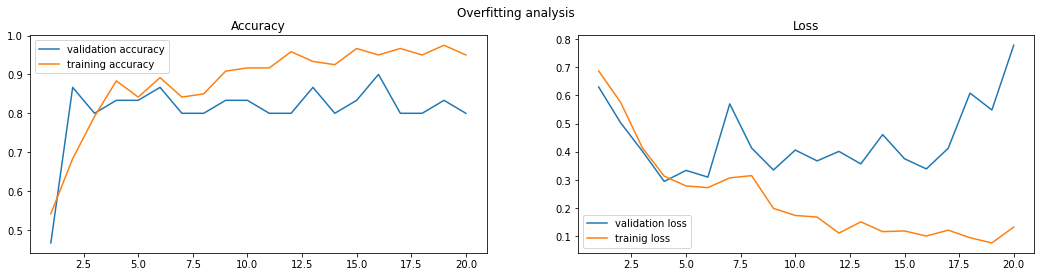

In [61]:
#Plotting accuracies and losses
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(18, 4)
fig.suptitle("Overfitting analysis")
axs[0].plot(list(range(1,21)), history.history['val_accuracy'], list(range(1,21)), history.history['accuracy'])

axs[0].title.set_text("Accuracy")
axs[0].legend(["validation accuracy", "training accuracy"])
axs[1].plot(list(range(1,21)), history.history['val_loss'], list(range(1,21)), history.history['loss'])
axs[1].title.set_text('Loss')
axs[1].legend(["validation loss", "trainig loss"])